In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
import eval_convnet_ctcf
import ucscgenome
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.signal import correlate2d
from sklearn.metrics import precision_recall_curve, roc_curve
from scipy.special import logit
import pysam
import matplotlib.pyplot as plt
import tqdm
import subprocess

In [13]:
# load in peak regions
# process the 1000 genomes data
snvs = pd.read_table('/home/kal/data/1000genomes_all_SNVs_motif.bed', header=None)
snvs.columns = 'chr varstart varend TF ref A C G T motif_count'.split()
snvs['motif'] = snvs['motif_count'] > 0
snvs['start'] = snvs['varstart'] - 128
snvs['end'] = snvs['varstart'] + 128
order = {'A':0, 'C':1, 'G':2, 'T':3}
rorder = ['A', 'C', 'G', 'T']
#ctcf_snvs = snvs[snvs.TF.apply(lambda x: 'CTCF' in x)].copy()
ctcf_snvs = snvs
ratios=list()
alts=list()
for index, row in ctcf_snvs.iterrows():
    counts = [row['A'], row['C'], row['G'], row['T']]
    ref_count = counts[order[row['ref']]]
    counts[order[row['ref']]] = 0
    alt_count = max(counts)
    alt = rorder[counts.index(alt_count)]
    ratio = alt_count/(ref_count + alt_count)
    ctcf_snvs.set_value(index,'alt', alt)
    ctcf_snvs.set_value(index,'allelicRatio', ratio)
    
# load the model
model_path = '/home/kal/CTCF/mass_CTCF/output/sigmoid/20170919_150754/20170919_150754_weights_3_248_0.91.hdf5'
model = load_model(model_path, custom_objects={'Bias':Bias})
layer_dict = dict([(layer.name, layer) for layer in model.layers])

get_act = K.function([model.input, K.learning_phase()], [layer_dict['bias'].output])

#load the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [15]:
# add annotations to the peaks
count = 0
file_length = len(ctcf_snvs)
for index, row in ctcf_snvs.iterrows():
    count = count + 1
    # get the sequence
    center = (row.start + row.end) // 2
    if center < 128:
        center = 128
    orig_seq = ctcfgen.encode(np.fromstring(genome[row.chr][center-128:center+128].lower(), dtype=np.uint8))
    new_seq = orig_seq.copy()
    new_seq[128:129] = ctcfgen.encode_string(row['alt'].lower())
    
    # add the model scores
    ctcf_snvs.set_value(index,'oml_score', get_act([np.asarray([orig_seq]*32),0])[0][0])
    ctcf_snvs.set_value(index,'nml_score', get_act([np.asarray([new_seq]*32),0])[0][0])

    # add the ctcf pwm scores
    score, pwm, meme, meme_index, position = ctcfgen.get_pwm([orig_seq], get_everything=True)
    ctcf_snvs.set_value(index,'octcf', score)
    ctcf_snvs.set_value(index,'ctcf_orentation', (meme_index>1))
    ctcf_snvs.set_value(index,'ctcf_position', position)
    score, pwm, _, _, position = ctcfgen.get_pwm([new_seq], get_everything=True, meme=meme, position=position)
    ctcf_snvs.set_value(index, 'nctcf', score)
    
     
    # add the mystery pwm scores
    score, pwm, meme, meme_index, position = ctcfgen.get_pwm([orig_seq], get_everything=True, meme_library='mystery_memes')
    ctcf_snvs.set_value(index,'omystery', score)
    ctcf_snvs.set_value(index,'mystery_orentation', (meme_index>0))
    ctcf_snvs.set_value(index,'mystery_position', position)
    score, pwm, meme, meme_index, position = ctcfgen.get_pwm([new_seq], get_everything=True, meme=meme, position=position, meme_library='mystery_memes')
    ctcf_snvs.set_value(index, 'nmystery', score)
    if count % (file_length/100) == 0:
        print(count / file_length * 100)
    
    
for index, row in ctcf_snvs.iterrows():
    ctcf_snvs.set_value(index, 'mystery', max(row['omystery'], row['nmystery']))
    ctcf_snvs.set_value(index, 'ctcf', max(row['octcf'], row['nctcf']))
    ctcf_snvs.set_value(index, 'ml_score', max(row['oml_score'], row['nml_score']))
    
    
ctcf_snvs['distance'] = abs(ctcf_snvs['mystery_position'] - ctcf_snvs['ctcf_position'])

In [6]:
for index, row in ctcf_snvs.iterrows():
    if row['distance'] > 0:
        # mystery upstream
        if (row['mystery_orentation'] < 1):
            #mystery forward
            if (row['ctcf_orentation'] < 1):
                # both forward
                ctcf_snvs.set_value(index, 'orentation', 1)
            else:
                # ctcf backward 
                ctcf_snvs.set_value(index, 'orentation', 4)
        else:
            # mystery backward
            if (row['ctcf_orentation'] < 1):
                # ctcf forward
                ctcf_snvs.set_value(index, 'orentation', 2)
            else:
                # both backward 
                ctcf_snvs.set_value(index, 'orentation', 3)
    else:
        # ctcf upstream
        if (row['mystery_orentation'] < 1):
            # mystery forward
            if (row['ctcf_orentation'] < 1):
                # both forward
                ctcf_snvs.set_value(index, 'orentation', 3)
            else:
                # ctcf backward 
                ctcf_snvs.set_value(index, 'orentation', 2)
        else:
            # mystery backward
            if (row['ctcf_orentation'] < 1):
                # ctcf forward
                ctcf_snvs.set_value(index, 'orentation', 4)
            else:
                # both backward 
                ctcf_snvs.set_value(index, 'orentation', 1)

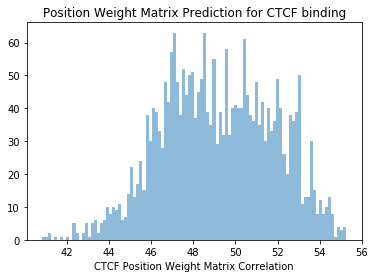

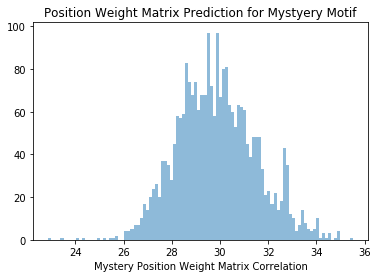

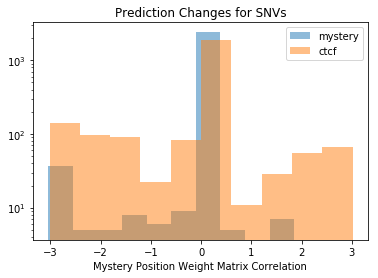

In [40]:
# get an idea of the score distribution
peaks = ctcf_snvs

plt.hist(ctcf_snvs['ctcf'], 100, alpha=.5)
plt.title('Position Weight Matrix Prediction for CTCF binding')
plt.xlabel('CTCF Position Weight Matrix Correlation')
plt.show()

plt.hist(ctcf_snvs['mystery'], 100, alpha=.5)
plt.title('Position Weight Matrix Prediction for Mystyery Motif')
plt.xlabel('Mystery Position Weight Matrix Correlation')
plt.show()

plt.hist(ctcf_snvs['nmystery'] - ctcf_snvs['omystery'] , alpha=.5, label='mystery')
#plt.hist(ctcf_snvs['nml_score'] - ctcf_snvs['oml_score'] , 100, alpha=.5, label='ml model')
plt.hist(ctcf_snvs['nctcf'] - ctcf_snvs['octcf'] , alpha=.5, label='ctcf')
plt.yscale('log', nonposy='clip')
plt.legend()
plt.title('Prediction Changes for SNVs')
plt.xlabel('Mystery Position Weight Matrix Correlation')
plt.show()

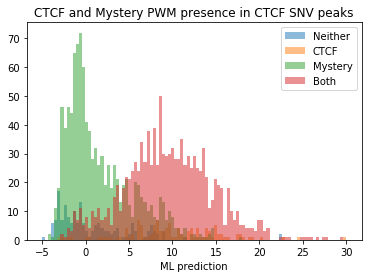

In [70]:
#split the data
ctcf_cutoff = 49
mystery_cutoff = 28

both = ctcf_snvs[(ctcf_snvs['ctcf'] > ctcf_cutoff) & (ctcf_snvs['mystery'] > mystery_cutoff)]
ctcf_only = ctcf_snvs[(ctcf_snvs['ctcf'] > ctcf_cutoff) & (ctcf_snvs['mystery'] < mystery_cutoff)]
mystery_only = ctcf_snvs[(ctcf_snvs['ctcf'] < ctcf_cutoff) & (ctcf_snvs['mystery'] > mystery_cutoff)]
neither = ctcf_snvs[(ctcf_snvs['ctcf'] < ctcf_cutoff) & (ctcf_snvs['mystery'] < mystery_cutoff)]

bins = np.linspace(-5, 30, 100)
plt.hist(neither['ml_score'], alpha=0.5, bins=bins, label='Neither')
plt.hist(ctcf_only['ml_score'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(mystery_only['ml_score'], alpha=0.5, bins=bins, label='Mystery')
plt.hist(both['ml_score'], alpha=0.5, bins=bins, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in CTCF SNV peaks')
plt.xlabel('ML prediction')
plt.show()

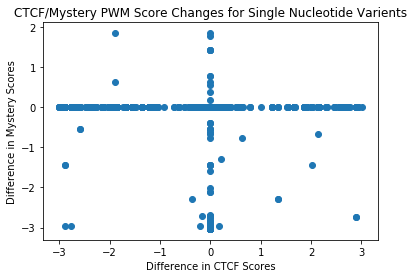

In [71]:
# plot score differencs 
filtered = ctcf_snvs[~((ctcf_snvs['ctcf'] < ctcf_cutoff) & (ctcf_snvs['mystery'] < mystery_cutoff))]
ratios = filtered['allelicRatio'].tolist()
mls = (filtered['nml_score'] - filtered['oml_score']) .tolist()
ctcfs = (filtered['nctcf'] - filtered['octcf']).tolist()
mysterys = (filtered['nmystery'] - filtered['omystery']).tolist()

#for two pwms
plt.scatter(ctcfs, mysterys)
plt.title('CTCF/Mystery PWM Score Changes for Single Nucleotide Varients')
plt.ylabel('Difference in Mystery Scores')
plt.xlabel('Difference in CTCF Scores')
plt.show()

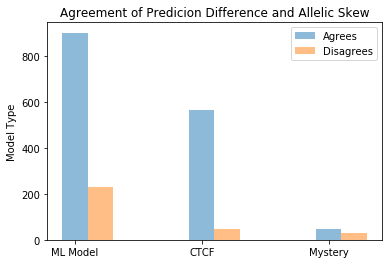

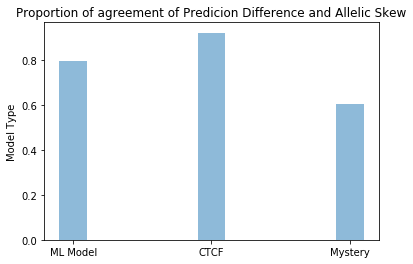

[900, 562, 46]
[230, 48, 30]


In [72]:
#look at pwms and models predictive power
cutoff = .1

objects = ('ML Model', 'CTCF', 'Mystery')
y_pos = np.arange(len(objects))
bar_width = 0.2

agrees = [0,0,0]
agrees[0] = len(filtered[((((filtered['nml_score'] - filtered['oml_score'])> cutoff) == (filtered['allelicRatio'] > .5)) & ~(abs(filtered['nml_score'] - filtered['oml_score']) < cutoff))])
agrees[1] = len(filtered[((((filtered['nctcf'] - filtered['octcf'])> cutoff) == (filtered['allelicRatio'] > .5))& ~(abs(filtered['nctcf'] - filtered['octcf']) < cutoff))])
agrees[2] = len(filtered[((((filtered['nmystery'] - filtered['omystery'])> cutoff) == (filtered['allelicRatio'] > .5))& ~(abs(filtered['nmystery'] - filtered['omystery']) < cutoff))])

differs = [0,0,0]
differs[0] = len(filtered[((((filtered['nml_score'] - filtered['oml_score'])> cutoff) == (filtered['allelicRatio'] < .5)) & ~(abs(filtered['nml_score'] - filtered['oml_score']) < cutoff))])
differs[1] = len(filtered[((((filtered['nctcf'] - filtered['octcf'])> cutoff) == (filtered['allelicRatio'] < .5))& ~(abs(filtered['nctcf'] - filtered['octcf']) < cutoff))])
differs[2] = len(filtered[((((filtered['nmystery'] - filtered['omystery'])> cutoff) == (filtered['allelicRatio'] < .5))& ~(abs(filtered['nmystery'] - filtered['omystery']) < cutoff))])

neutral = [0,0,0]
neutral[0] = len(filtered[(abs(filtered['nml_score'] - filtered['oml_score']) < cutoff)])
neutral[1] = len(filtered[(abs(filtered['nctcf'] - filtered['octcf']) < cutoff)])
neutral[2] = len(filtered[(abs(filtered['nmystery'] - filtered['omystery']) < cutoff)])
 
plt.bar(y_pos, agrees, bar_width, alpha=0.5, label='Agrees')
plt.bar(y_pos + bar_width, differs, bar_width, alpha=0.5, label='Disagrees')
#plt.bar(y_pos + 2*bar_width, neutral, bar_width, alpha=0.5, label='No Change')
plt.xticks(y_pos, objects)
plt.ylabel('Model Type')
plt.legend()
plt.title('Agreement of Predicion Difference and Allelic Skew')
 
plt.show()

# plot agree/total that have change
props = [a/(a+d) for a, d in zip(agrees, differs)]
plt.bar(y_pos, props , bar_width, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Model Type')
plt.title('Proportion of agreement of Predicion Difference and Allelic Skew')

plt.show()
print(agrees)
print(differs)

In [ ]:
filtered = both
#filtered = ctcf_snvs[~(ctcf_snvs['pwm_motif'])]
#filtered = filtered[(filtered['diffpred']!=0)]
ratios = filtered['allelicRatio'].tolist()
mls = (filtered['nml_score'] - filtered['oml_score']) .tolist()
ctcfs = (filtered['nctcf'] - filtered['octcf']).tolist()
mysterys = (filtered['nmystery'] - filtered['omystery']).tolist()

#for two pwms
plt.hexbin(ctcfs, mysterys, gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF/Mystery PWM Score Changes for Single Nucleotide Varients')
plt.ylabel('Difference in Mystery Scores')
plt.xlabel('Difference in CTCF Scores')
plt.show()

# for each pwm vs model
plt.hexbin(ctcfs, mls, gridsize=50, bins='log', cmap='plasma')
plt.title('PWM/ Model Comparison for Single Nucleotide Varients')
plt.ylabel('Difference in Model Score')
plt.xlabel('Difference in CTCF Scores')
plt.show()

plt.hexbin(mysterys, mls, gridsize=50, bins='log', cmap='plasma')
plt.title('PWM/ Model Comparison for Single Nucleotide Varients')
plt.ylabel('Difference in Model Score')
plt.xlabel('Difference in Mystery Scores')
plt.show()

# for each predictor vs actual 
plt.hexbin(ratios, mysterys, gridsize=50, bins='log', cmap='plasma')
plt.title('Mystery PWMs predictive power for Single Nucleotide Varients')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Mystery PWM Score')
plt.show()

plt.hexbin(ratios, ctcfs, gridsize=50, bins='log', cmap='plasma')
plt.title('CTCF PWMs predictive power for Single Nucleotide Varients')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in CTCF PWM Score')
plt.show()

plt.hexbin(ratios, mls, gridsize=50, bins='log', cmap='plasma')
plt.title('DL Models predictive power for Single Nucleotide Varients')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in ML Model Score')
plt.show()

46


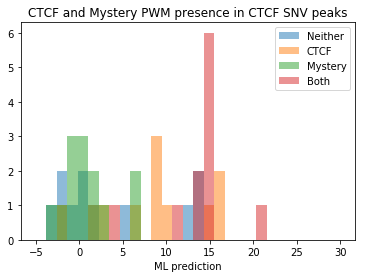

In [73]:
# analyze peaks with mystery change
filtered = ctcf_snvs[~((ctcf_snvs['ctcf'] < ctcf_cutoff) & (ctcf_snvs['mystery'] < mystery_cutoff))]

filtered = filtered[((((filtered['nmystery'] - filtered['omystery'])> cutoff) == (filtered['allelicRatio'] > .5))& ~(abs(filtered['nmystery'] - filtered['omystery']) < cutoff))]
print(len(filtered))

#split the data
ctcf_cutoff = 49
mystery_cutoff = 30

both = filtered[(filtered['ctcf'] > ctcf_cutoff) & (filtered['mystery'] > mystery_cutoff)]
ctcf_only = filtered[(filtered['ctcf'] > ctcf_cutoff) & (filtered['mystery'] < mystery_cutoff)]
mystery_only = filtered[(filtered['ctcf'] < ctcf_cutoff) & (filtered['mystery'] > mystery_cutoff)]
neither = filtered[(filtered['ctcf'] < ctcf_cutoff) & (filtered['mystery'] < mystery_cutoff)]

bins = np.linspace(-5, 30, 30)
plt.hist(neither['ml_score'], alpha=0.5, bins=bins, label='Neither')
plt.hist(ctcf_only['ml_score'], alpha=0.5, bins=bins, label='CTCF')
plt.hist(mystery_only['ml_score'], alpha=0.5, bins=bins, label='Mystery')
plt.hist(both['ml_score'], alpha=0.5, bins=bins, label='Both')
plt.legend()
plt.title('CTCF and Mystery PWM presence in CTCF SNV peaks')
plt.xlabel('ML prediction')
plt.show()

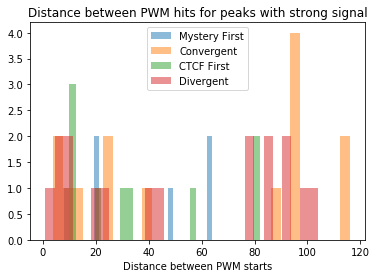

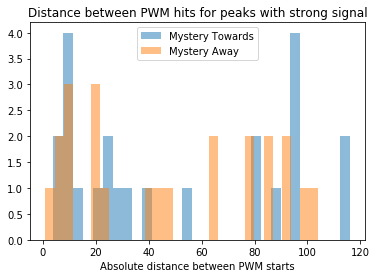

In [75]:
plt.hist(filtered[(filtered['orentation'] == 1)]['distance'], bins = 30, alpha = 0.5, label = 'Mystery First')
plt.hist(filtered[(filtered['orentation'] == 2)]['distance'], bins = 30, alpha = 0.5, label = 'Convergent')
plt.hist(filtered[(filtered['orentation'] == 3)]['distance'], bins = 30, alpha = 0.5, label = 'CTCF First')
plt.hist(filtered[(filtered['orentation'] == 4)]['distance'], bins = 30, alpha = 0.5, label = 'Divergent')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Distance between PWM starts')
plt.show()

plt.hist(filtered[(abs(filtered['orentation']-2.5) < 1)]['distance'], bins = 30, alpha = 0.5, label = 'Mystery Towards')
plt.hist(filtered[~(abs(filtered['orentation'] -2.5) < 1)]['distance'], bins = 30, alpha = 0.5, label = 'Mystery Away')

plt.legend()
plt.title('Distance between PWM hits for peaks with strong signal')
plt.xlabel('Absolute distance between PWM starts')
plt.show()